In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object
# Changed this to Round Scores
ts_data = pd.Series(power['Round_total'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]


C:\Users\killi\AppData\Local\Temp/ipykernel_26756/3752936543.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_26756/3752936543.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_26756/3752936543.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [2]:
# Build a Stan Model using a simple regression

import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Get observed scores to use for model
observed_round_score = train_series.values

# Don't need y hat - what I need is to generate values for Y
# this will have a standard deviation of 3

model_code = """
data {
  int<lower=0> N; //number of rows in training set
  vector[N] y;
} 

parameters {  
  
// golfer parameters
  real golfer_estimate;

// residual error in likelihood
  real<lower=0.00001> sigma_y;
} 

model {
      // Set priors     
      sigma_y ~ normal(0, 100); 
      
    // Likelihood
    y ~ normal(golfer_estimate, sigma_y);
}


generated quantities {
 // generate simulated values for y
  vector[N] y_sim;
  for (i in 1:N)
  y_sim[i] = normal_rng(golfer_estimate, sigma_y);
}

"""

model_data = {'N': len(observed_round_score),
               'y': observed_round_score}


# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# Call sampling function with data as argument
# Use 2 chains with 1k iterations each - 500 burn in - this will give 1k
fit = stan_model.sampling(data=model_data, iter=1000, chains=2, seed=1)

# Put Posterior draws into a dictionary
trace = fit.extract()


# Put simulations into an array
y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
# statistics are almos the same as statsmodel model
trace_summary


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00703864a8c8aa169afb232794c36fb9 NOW.


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
golfer_estimate,71.214045,0.014105,0.387803,70.455411,70.957544,71.221556,71.453337,71.981913,755.936379,1.002230
sigma_y,3.313259,0.008439,0.262584,2.832171,3.136352,3.289799,3.477833,3.882294,968.249787,0.999312
y_sim[1],71.250982,0.106341,3.394563,64.509242,69.047582,71.263164,73.475728,77.842198,1018.983805,0.999661
y_sim[2],71.241290,0.111543,3.269990,64.904944,69.074743,71.270336,73.290838,77.830023,859.425529,0.999909
y_sim[3],71.306125,0.109198,3.301581,64.595135,69.185290,71.336677,73.500683,77.901799,914.144381,0.999245
...,...,...,...,...,...,...,...,...,...,...
y_sim[77],71.206589,0.109921,3.452118,63.960695,68.939086,71.221463,73.573191,77.644509,986.299585,0.999787
y_sim[78],71.132612,0.105097,3.324307,64.787163,68.913677,71.048685,73.324850,77.866946,1000.501210,0.999585
y_sim[79],71.279330,0.106521,3.484025,64.155950,69.080595,71.463861,73.609944,77.657279,1069.764442,0.998896
y_sim[80],71.159557,0.108962,3.419364,64.483804,68.751661,71.177735,73.570499,77.675551,984.789830,1.002350


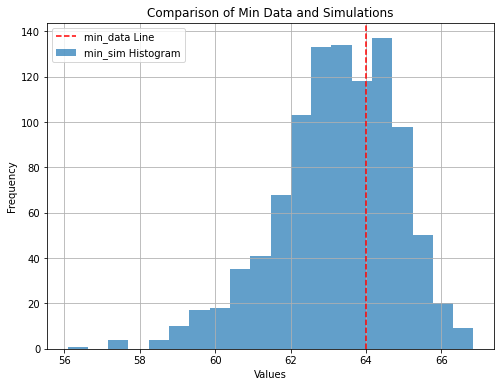

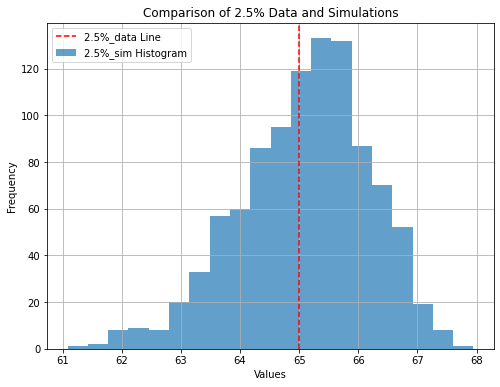

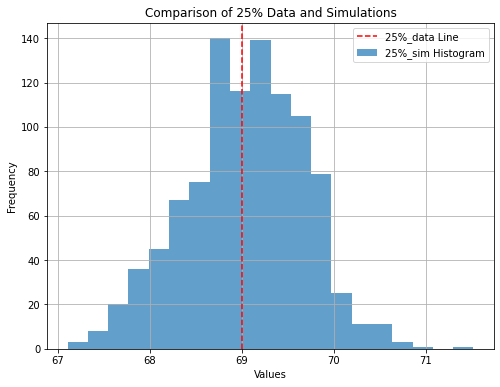

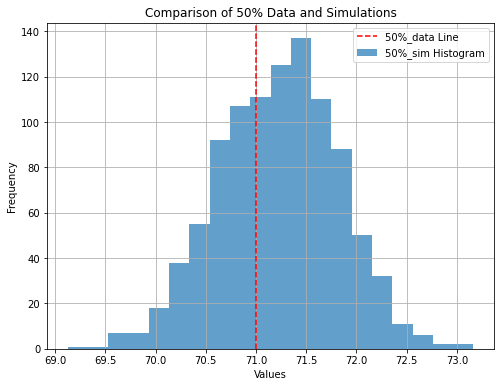

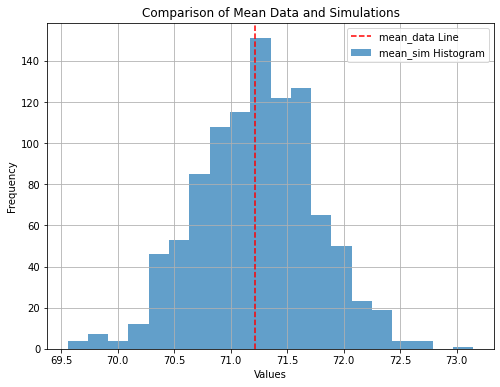

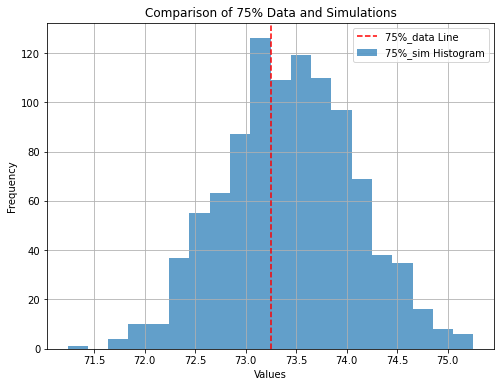

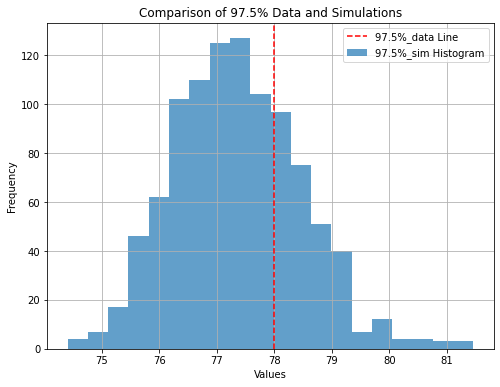

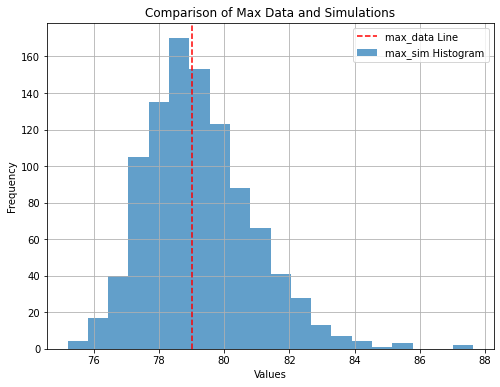

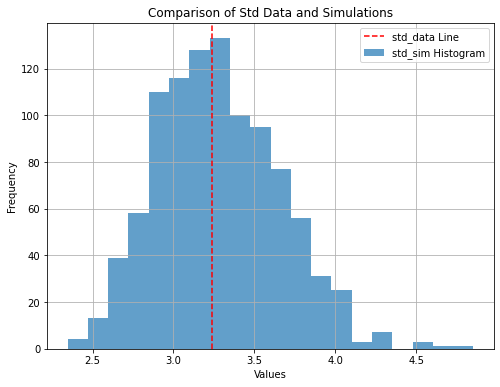

In [3]:
# Normal distribution - for count data
# Fits the data the best so far - even though too much data in the tails

import numpy as np


# Define statistics to loop through
# Will have 1k values for each value 
# Taking the min of 80 obs 
statistics = {
    'min': (np.min(observed_round_score), np.min(y_sim, axis=1)),
    '2.5%': (np.percentile(observed_round_score,2.5),np.percentile(y_sim,2.5,axis=1)),
    '25%': (np.percentile(observed_round_score,25),np.percentile(y_sim,25,axis=1)),
    '50%': (np.percentile(observed_round_score,50),np.percentile(y_sim,50,axis=1)),
    'mean': (np.mean(observed_round_score), np.mean(y_sim, axis=1)),
    '75%': (np.percentile(observed_round_score,75),np.percentile(y_sim,75,axis=1)),
    '97.5%': (np.percentile(observed_round_score,97.5),np.percentile(y_sim,97.5,axis=1)),
    'max': (np.max(observed_round_score), np.max(y_sim, axis=1)),
    'std': (np.std(observed_round_score), np.std(y_sim, axis=1))
}

# Plotting loop
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()

